Cloning Repo and installing dependencies

In [ ]:
!git clone https://github.com/egochao/DeePromoter.git
%cd DeePromoter
#!pip install -r requirements.txt
!pip install icecream

Cloning into 'DeePromoter'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 60 (delta 20), reused 47 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 4.83 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (20/20), done.


##### Training and/or loading DeePromoter model

In [11]:
import torch
import math
import argparse
import torch.optim as optim
from torch import nn
from icecream import ic
from pathlib import Path

from modules.deepromoter import DeePromoter
from dataloader import load_data_test, load_data
from DeePromoter.test import evaluate, mcc
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(data_path, pretrain=None, exp_name="test", training=True, ker=None, epoch_num=1000):
    """
    Training
    :param data_path: Path to the txt data file
    :param pretrain: Path to weight for continue training
    :param exp_name: Folder name to save the results
    :param training: If False, performs testing only
    :param ker: List kernel size of list CNN applying to the protein sequence
    :param epoch_num: Max epoch to train
    """
    if ker is None:
        ker = [27, 14, 7]

    # create the experiment folder to save the result
    output = Path("./output")
    output.mkdir(exist_ok=True)
    exp_folder = output.joinpath(exp_name)
    exp_folder.mkdir(exist_ok=True)

    # load data
    ic("Data loading")
    data = load_data(data_path, device=device)
    train_pos, val_pos, test_pos, train_neg, val_neg, test_neg = data

    # model define
    net = DeePromoter(ker)
    net.to(device)

    # load pre-train model
    if pretrain is not None:
        net.load_state_dict(torch.load(pretrain))

    # define loss, optimizer
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.00001)
    mcc_scores, precision_scores, recall_scores = [], [], []
    running_loss = 0
    best_mcc = 0
    best_precision = 0
    best_recall = 0
    break_after = 10
    last_update_best = 0
    pbar = range(epoch_num)
    ic("Start training")
    if training:
        for epoch in pbar:
            for i, (batch_pos, batch_neg) in enumerate(zip(train_pos, train_neg)):
                inputs = torch.cat((batch_pos[0], batch_neg[0]), dim=0)
                labels = torch.cat((batch_pos[1], batch_neg[1]), dim=0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # pass model to
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()


            if epoch % 10 == 0:
                torch.save(net.state_dict(), str(exp_folder.joinpath("epoch_" + str(epoch) + ".pth")))
                net.eval()
                eval_data, _ = evaluate(net, [val_pos, val_neg])
                precision, recall, MCC = mcc(eval_data)
                mcc_scores.append(MCC)
                precision_scores.append(precision)
                recall_scores.append(recall)
                net.train()
                ic("Epoch :", epoch, "Experiment :", exp_name)
                ic("precision :", precision)
                ic("recall :", recall)
                ic("MCC :", MCC)

                # save best model
                if precision > best_precision:
                    best_precision = precision
                    ic("Update best precision")
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_precision.pth")))
                if recall > best_recall:
                    best_recall = recall
                    ic("Update best recall")
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_recall.pth")))
                if MCC > best_mcc:
                    ic("Update best MCC")
                    best_mcc = MCC
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_mcc.pth")))
                    last_update_best = 0
                else:
                    last_update_best += 1
                if last_update_best >= break_after:
                    break
            if last_update_best >= break_after:
                break

    return mcc_scores, precision_scores, recall_scores



In [ ]:
#you can train the model yourself (uncomment the section to do so) but it takes approx 1hour on gpu
data_path_human_noTATA = "./data/human/nonTATA/hs_pos_nonTATA.txt"
mcc_scores_no, precision_scores_no, recall_scores_no = train(data_path_human_noTATA, pretrain=None, exp_name="train_human_noTATA", training=True, ker=None, epoch_num=400)


ic| 'Data loading'


Key error :  N 200
Key error :  N 200


ic| 'Start training'
ic| "Epoch :": 'Epoch :'
    epoch: 0
    "Experiment :": 'Experiment :'
    exp_name: 'train_human_noTATA'
ic| 'precision :', precision: 0.7374429223744292
ic| 'recall :', recall: 0.6233114627556928
ic| 'MCC :', MCC: 0.40628471819514456
ic| 'Update best precision'
ic| 'Update best recall'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 10
    "Experiment :": 'Experiment :'
    exp_name: 'train_human_noTATA'
ic| 'precision :', precision: 0.8882947118241236
ic| 'recall :', recall: 0.5769972983404091
ic| 'MCC :', MCC: 0.5385940587090312
ic| 'Update best precision'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 20
    "Experiment :": 'Experiment :'
    exp_name: 'train_human_noTATA'
ic| 'precision :', precision: 0.8963075366717248
ic| 'recall :', recall: 0.6839058278656889
ic| 'MCC :', MCC: 0.6225176149677563
ic| 'Update best precision'
ic| 'Update best recall'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 30
    "Experiment :": 'Exper

##### check the performance

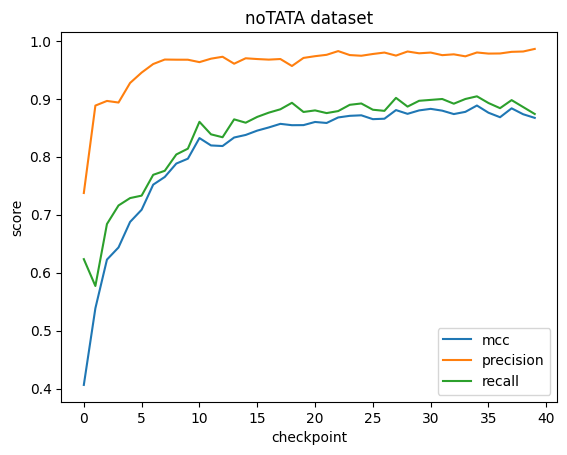

In [ ]:
plt.plot(mcc_scores_no, label='mcc')
plt.plot(precision_scores_no, label='precision')
plt.plot(recall_scores_no, label='recall')
plt.title('noTATA dataset')
plt.legend()
plt.xlabel('checkpoint')
plt.ylabel('score')
plt.show()

The plot above shows the metrics reflecting the model's learning progress.

In [15]:
#we will load already trained model here
path_noTATA_pretrained_model = './data/models/model_noTATA.pth'

In [16]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, ax=None):
    """
    Plot the confusion matrix using matplotlib without labels and seaborn.
    :param cm: confusion matrix
    :param ax: axis to plot on, if None a new plot will be created
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the confusion matrix
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)

    # Annotate the confusion matrix cells with the counts
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, str(val), ha='center', va='center', color='black', fontsize=14)

    ax.set_xlabel('Predicted Labels', fontsize=14)
    ax.set_ylabel('True Labels', fontsize=14)
    ax.set_title('Confusion Matrix', fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

def evaluate(net, loaders):
    """
    Infer and check results against labels
    :param net: Model object in eval state
    :param loaders: List of torch dataloader for infer
    :return: List of [correct, total] for every dataloader, list of predicted results in int type, list of confusion matrices
    """
    eval_result = list()
    ltotal = list()
    lcorrect = list()
    pred_result = list()
    true_result = list()  # To store the true labels for further analysis

    for load in loaders:
        total = 0
        correct = 0
        pred_list = list()
        true_list = list()  # To store true labels for confusion matrix

        for data in load:
            inputs = data[0]
            labels = data[1]
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_list += list(predicted.cpu().numpy())
            true_list += list(labels.cpu().numpy())


        acc = correct / total
        eval_result.append(acc)
        lcorrect.append(correct)
        ltotal.append(total)
        pred_result.append(pred_list)
        true_result.append(true_list)

        # Compute confusion matrix for this dataloader
        cm = confusion_matrix(true_list, pred_list)


    return (lcorrect, ltotal), pred_result, cm


Use the function suggested by the authors of the repository. For testing the model, they input only promoters (without modifications, i.e., the negative dataset) and then check how many of these were classified as positive examples of promoters.

In [17]:
def test(data_path, pretrain,device,ker=None):
    if ker is None:
        ker = [27, 14, 7]

    dataloader = load_data_test(data_path=data_path, batch_size=32, device=device, num_cpu=10)

    # model define
    net = DeePromoter(ker)
    net.to(device)

    net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))


    net.eval()
    eval_data, results, confusion_matrice = evaluate(net, [dataloader])

    return eval_data, results, confusion_matrice

In [18]:
eval_data, results, confusion_matrice = test('/content/DeePromoter/data/human/nonTATA/hs_pos_nonTATA.txt', pretrain=path_noTATA_pretrained_model, device=device, ker=None)

Key error :  N 200


In [19]:
positives = 0
all = 0
for example in results[0]:
  positives += example
  all += 1
print(f'Out of {all} promoters model predicted {positives} postitive promoters which is {round((positives/all),2)*100}%')

Out of 25920 promoters model predicted 24343 postitive promoters which is 94.0%


Modify the function provided by the authors to evaluate the model's performance in a more standard machine learning approach, using a test dataset with positive and negative examples separated during the data preparation process.

In [20]:
from torch.utils.data import DataLoader, ConcatDataset

def test_new(data_path, pretrain, ker=None):
    if ker is None:
        ker = [27, 14, 7]

    dataloader = load_data(data_path, device=device)
    # Assuming `positive_dataloader` and `negative_dataloader` are already defined in the repository files
    positive_dataloader = dataloader[2]  # Your DataLoader for positive examples
    negative_dataloader = dataloader[5]  # Your DataLoader for negative examples

    # Extract datasets from each DataLoader
    positive_dataset = positive_dataloader.dataset
    negative_dataset = negative_dataloader.dataset

    # Combine the datasets
    combined_dataset = ConcatDataset([positive_dataset, negative_dataset])

    # Create a new DataLoader from the combined dataset
    combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

    # model define
    net = DeePromoter(ker)
    net.to(device)

    net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))

    net.eval()
    eval_data, results, confusion_matrice = evaluate(net, [combined_dataloader])

    return eval_data, results, confusion_matrice




Key error :  N 200
Key error :  N 200


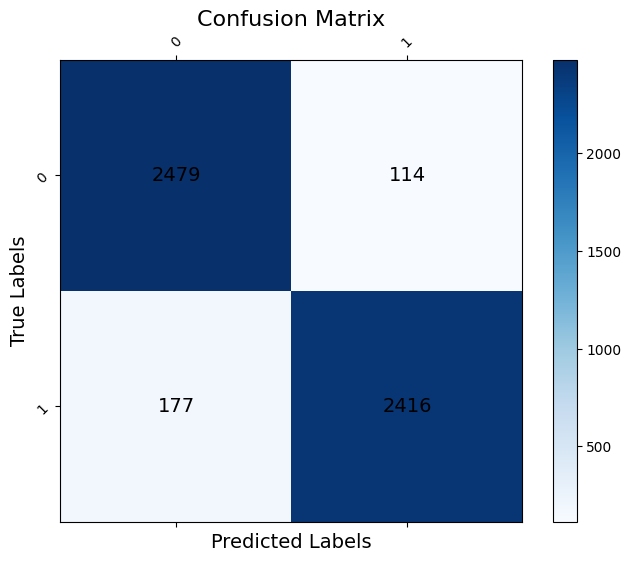

In [21]:
eval_data_noTATA, results_noTATA , confusion_matrice_noTATA = test_new('/content/DeePromoter/data/human/nonTATA/hs_pos_nonTATA.txt',path_noTATA_pretrained_model )
plot_confusion_matrix(confusion_matrice_noTATA)

In [22]:
accuracy_noTATA = eval_data_noTATA[0][0]/eval_data_noTATA[1][0]
print(f'The accuracy of the DeePromoter basedthe nonTATA dataset is {round(accuracy_noTATA,2)*100}%')

The accuracy of the DeePromoter basedthe nonTATA dataset is 94.0%


It demonstrated that DeePromoter performs well on the provided dataset, which consists of promoters with random modifications as the negative examples. But does this prove that it generalizes effectively? What happens if we input completely random sequences from the human genome? Let's test it. We'll use a ready-made file where the sequences are downloaded from Ensembl.

##### Testing the model on random sequences from human genome

In [23]:
path_random_sequences = './data/sequences/random_sequences_25920.txt'

In [31]:
eval_data_random_noTATA, results_random_noTATA, confusion_matrice_random_noTATA = test(path_random_sequences, pretrain=path_noTATA_pretrained_model,device=device ,ker=None)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [32]:
positives = 0
all = 0
for example in results_random_noTATA[0]:
  positives += example
  all += 1
print(f'Out of {all} all uncut sequences model predicted {positives} postitives which is {round((positives/all),2)*100}%')

Out of 25920 all uncut sequences model predicted 23242 postitives which is 90.0%


We have completely random genomic sequences, and the model predicted most of them as promoters, similar to what happened when we used the dataset consisting only of promoters. What happens when we cut the random genomic sequences and mix some parts of them, as done in the negative dataset preparation for the original paper?

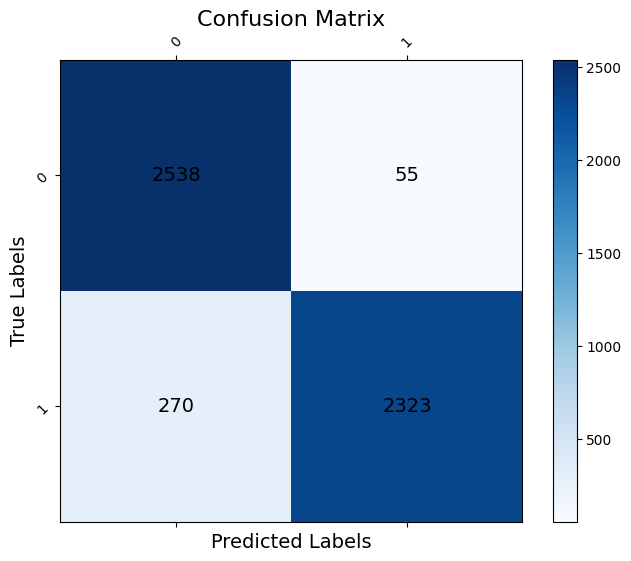

In [26]:
eval_data_random_noTATA, results_random_noTATA, confusion_matrice_random_noTATA = test_new(path_random_sequences, pretrain=path_noTATA_pretrained_model, ker=None)
plot_confusion_matrix(confusion_matrice_random_noTATA)

In [27]:
accuracy_noTATA_model = eval_data_random_noTATA[0][0]/eval_data_random_noTATA[1][0]
print(f'The accuracy of the DeePromoter for random sequences is {round(accuracy_noTATA_model,2)*100}%')

The accuracy of the DeePromoter for random sequences is 94.0%


This result proves that the model is not well-suited for distinguishing promoter regions. Whether we provide true promoters as the positive dataset or use completely random sequences, the model's performance remains similarly high. This indicates that the model is learning to distinguish the artificial shuffling in sequences.

##### Conclusion
The model trained on a dataset consisting only of promoters and a negative set created from modified promoters performs well when focusing solely on machine learning metrics and results. However, this highlights the importance of understanding the data we’re working with. DeePromoter, trained only on promoters (with negative examples derived from positive ones), produces the same results for completely random sequences from human genome.

### Random sequences vs promoters

Now, let's adjust the original functions to utilize the model for distinguishing between real promoters and random sequences from the human genome. Files containing both promoters and random sequences are included in /data/sequences/ .

In [ ]:
path_promotors = './data/sequences/promoters.txt'
path_random_nopromotors = "./data/sequences/random_sequences_nopromoters.txt"

In [ ]:
from dataloader import LoadOnehot
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

def load_data_new(data_path_promotors,data_path_random ,train_potion=0.8, batch_size=32, num_cpu=0, device="cuda"):
    """
    Load all data
    :param data_path: Path to txt file contain promoter (1 DNA promoter on 1 line)
    :param train_potion: The potion of dataset spend for training
    :param rand_neg: Add random of DNA to negative datset
    :param batch_size: Batch size for loader
    :param num_cpu: Number of CPU perform load data in prallel
    :param device: Device to load data on
    :return: List of train, val, test dataset for positive and negative datset
    """
    # get dataset
    manual_seed = torch.Generator().manual_seed(42)
    pos_data = LoadOnehot(data_path_promotors, device=device)

    #YOUR CODE HERE
    #Tip: examine LoadOnehot class in dataloader file
    #neq_data = YOUR CODE HERE

    #Solution
    neg_data = LoadOnehot(data_path_random,is_pos=False,device=device)

    # calculate the size of train and test dataset
    train_num = int(len(pos_data)*train_potion)
    val_num = int(len(pos_data)*(1-train_potion)*0.5)
    split_size = [train_num, val_num, len(pos_data) - train_num - val_num]

    # split dataset
    train_pos, val_pos, test_pos = random_split(pos_data, split_size, generator=manual_seed)
    train_neg, val_neg, test_neg = random_split(neg_data, split_size, generator=manual_seed)

    # data loader
    stack_dataset = [train_pos, val_pos, test_pos, train_neg, val_neg, test_neg]
    stack_loaders = list()
    for dataset in stack_dataset:
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
        stack_loaders.append(data_loader)

    return stack_loaders


Check if your datasets have the same lenght to avoid the bias by over representation of one class.

In [ ]:
#Solution
pos_data_len = LoadOnehot(path_promotors, device=device).__len__()
neg_data_len = LoadOnehot(path_random_nopromotors,is_pos=False,device=device).__len__()
if pos_data_len == neg_data_len:
  print(f"The datasets have the same lenght of {pos_data_len}")
else:
  print("The datasets have different lenght")
  print("Positive dataset: ", pos_data_len)
  print("Negative dataset: ", neg_data_len)


Key error :  N 200
The datasets have the same lenght of 28849


Train the model that takes promoters as positive examples and random sequences as negative.

In [ ]:
def train_new(data_path_promotors,data_path_random, pretrain=None, exp_name="test", training=True, ker=None, epoch_num=1000):
    """
    Training
    :param data_path: Path to the txt data file
    :param pretrain: Path to weight for continue training
    :param exp_name: Folder name to save the results
    :param training: If False, performs testing only
    :param ker: List kernel size of list CNN applying to the protein sequence
    :param epoch_num: Max epoch to train
    """
    if ker is None:
        ker = [27, 14, 7]

    # create the experiment folder to save the result
    output = Path("./output")
    output.mkdir(exist_ok=True)
    exp_folder = output.joinpath(exp_name)
    exp_folder.mkdir(exist_ok=True)

    # load data
    ic("Data loading")
    data = load_data_new(data_path_promotors,data_path_random,device=device)
    train_pos, val_pos, test_pos, train_neg, val_neg, test_neg = data

    # model define
    net = DeePromoter(ker)
    net.to(device)

    # load pre-train model
    if pretrain is not None:
        net.load_state_dict(torch.load(pretrain))

    # define loss, optimizer
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.00001)
    mcc_scores, precision_scores, recall_scores = [], [], []
    running_loss = 0
    best_mcc = 0
    best_precision = 0
    best_recall = 0
    break_after = 10
    last_update_best = 0
    pbar = range(epoch_num)
    ic("Start training")
    if training:
        for epoch in pbar:
            for i, (batch_pos, batch_neg) in enumerate(zip(train_pos, train_neg)):
                inputs = torch.cat((batch_pos[0], batch_neg[0]), dim=0)
                labels = torch.cat((batch_pos[1], batch_neg[1]), dim=0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # pass model to
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()


            if epoch % 10 == 0:
                torch.save(net.state_dict(), str(exp_folder.joinpath("epoch_" + str(epoch) + ".pth")))
                net.eval()
                eval_data, _ , _= evaluate(net, [val_pos, val_neg])
                precision, recall, MCC = mcc(eval_data)
                mcc_scores.append(MCC)
                precision_scores.append(precision)
                recall_scores.append(recall)
                net.train()
                ic("Epoch :", epoch, "Experiment :", exp_name)
                ic("precision :", precision)
                ic("recall :", recall)
                ic("MCC :", MCC)

                # save best model
                if precision > best_precision:
                    best_precision = precision
                    ic("Update best precision")
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_precision.pth")))
                if recall > best_recall:
                    best_recall = recall
                    ic("Update best recall")
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_recall.pth")))
                if MCC > best_mcc:
                    ic("Update best MCC")
                    best_mcc = MCC
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_mcc.pth")))
                    last_update_best = 0
                else:
                    last_update_best += 1
                if last_update_best >= break_after:
                    break
            if last_update_best >= break_after:
                break

    return mcc_scores, precision_scores, recall_scores




In [ ]:
mcc_scores, precision_scores, recall_scores = train_new(path_promotors,path_random_nopromotors  ,pretrain=None, exp_name="train_promoters_random", training=True, ker=None, epoch_num=400)


ic| 'Data loading'


Key error :  N 200


ic| 'Start training'
ic| "Epoch :": 'Epoch :'
    epoch: 0
    "Experiment :": 'Experiment :'
    exp_name: 'train_promoters_random'
ic| 'precision :', precision: 0.7885345482156416
ic| 'recall :', recall: 0.7201803051317615
ic| 'MCC :', MCC: 0.5290371944270882
ic| 'Update best precision'
ic| 'Update best recall'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 10
    "Experiment :": 'Experiment :'
    exp_name: 'train_promoters_random'
ic| 'precision :', precision: 0.8385437277404036
ic| 'recall :', recall: 0.734743411927878
ic| 'MCC :', MCC: 0.5978715297098016
ic| 'Update best precision'
ic| 'Update best recall'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 20
    "Experiment :": 'Experiment :'
    exp_name: 'train_promoters_random'
ic| 'precision :', precision: 0.8474508229626656
ic| 'recall :', recall: 0.7319694868238558
ic| 'MCC :', MCC: 0.6058595855317958
ic| 'Update best precision'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 30
    "Experiment 

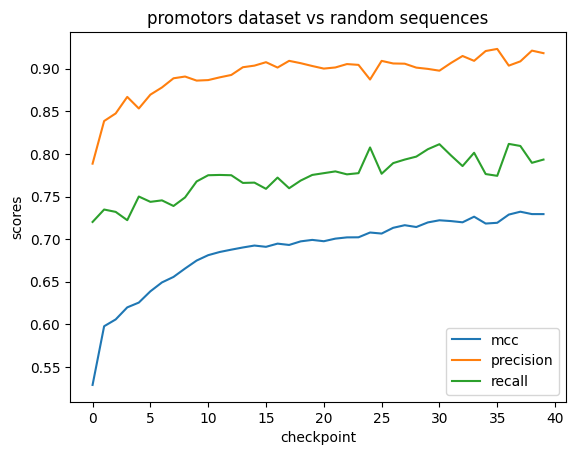

In [ ]:
plt.plot(mcc_scores, label='mcc')
plt.plot(precision_scores, label='precision')
plt.plot(recall_scores, label='recall')
plt.title('promotors dataset vs random sequences')
plt.xlabel('checkpoint')
plt.ylabel('scores')
plt.legend()
plt.show()

In [ ]:
def test_new(data_path_promotors,data_path_human_random ,pretrain, ker=None):
    if ker is None:
        ker = [27, 14, 7]

    dataloader = load_data_new(data_path_promotors,data_path_human_random ,device=device)
    # Assuming `positive_dataloader` and `negative_dataloader` are already defined in the repository files
    positive_dataloader = dataloader[2]  # Your DataLoader for positive examples
    negative_dataloader = dataloader[5]  # Your DataLoader for negative examples

    # Extract datasets from each DataLoader
    positive_dataset = positive_dataloader.dataset
    negative_dataset = negative_dataloader.dataset

    # Combine the datasets
    combined_dataset = ConcatDataset([positive_dataset, negative_dataset])

    # Create a new DataLoader from the combined dataset
    combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

    # model define
    net = DeePromoter(ker)
    net.to(device)

    net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))

    net.eval()
    eval_data, results, confusion_matrice = evaluate(net, [combined_dataloader])

    return eval_data, results, confusion_matrice


In [ ]:
#Load pretrained model
path_promotors_random_model = './data/models/model_random_promotors.pth'

Plot confusion matrix and compute accuracy for the new model. What do you think about the results?

Key error :  N 200


<ipython-input-26-5b43c94fcdf0>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))


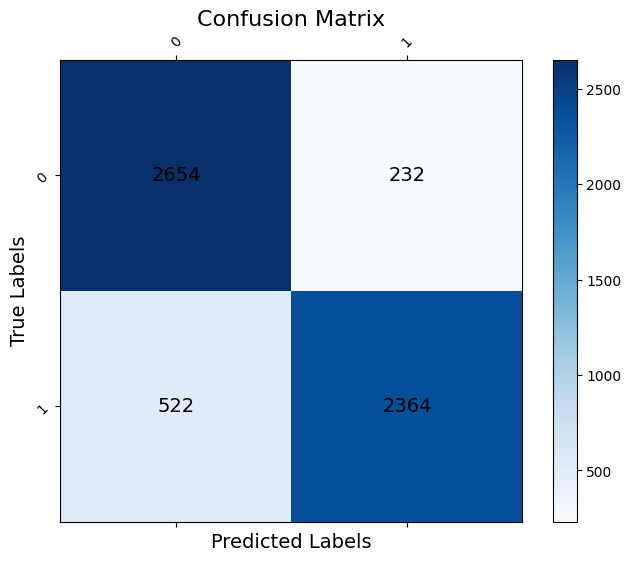

In [ ]:
eval_data_random_promotors, results_random_promotors, confusion_matrice_random_promotors = test_new(path_promotors,path_random_nopromotors, path_promotors_random_model, ker=None)
plot_confusion_matrix(confusion_matrice_random_promotors)

In [ ]:
accuracy_random_promotors = eval_data_random_promotors[0][0]/eval_data_random_promotors[1][0]
print(f'The accuracy of the DeePromoter for random genomic sequences is {round(accuracy_random_promotors,2)*100}%')

The accuracy of the DeePromoter for random sequences is 87.0%


### Summary
The results demonstrated that Deepromoter is a model with strong performance metrics. However, a deeper analysis of the problem and the data suggests that the tool isn't fulfilling its intended purpose. While Deepromoter excels at distinguishing sequence randomization, it falls short when it comes to identifying true promoter genomic regions from non-promoter genomic regions.

# Plot the distribution of nucleotides in both the promoter and random sequence datasets. Are there any noticeable differences?

In [ ]:
def calculate_nucleotide_percentage(dna_sequence):
    # Count the occurrences of each nucleotide
    total_length = len(dna_sequence)
    counts = {
        'A': dna_sequence.count('A'),
        'T': dna_sequence.count('T'),
        'C': dna_sequence.count('C'),
        'G': dna_sequence.count('G')
    }

    # Calculate percentage for each nucleotide
    percentages = {nucleotide: (count / total_length) * 100 for nucleotide, count in counts.items()}
    return percentages

def calculate_mean_percentages(percentages_list):
    # Calculate the mean of percentages for each nucleotide across all examples
    mean_percentages = {}
    for nucleotide in ['A', 'T', 'C', 'G']:
        mean_percentages[nucleotide] = sum(p[nucleotide] for p in percentages_list) / len(percentages_list)
    return mean_percentages

def compute_nuckl_dis(file_path):
    with open(file_path, 'r') as file:
        dna_sequences = file.readlines()

    # Strip any extra whitespace or newlines
    dna_sequences = [seq.strip() for seq in dna_sequences]

    percentages_list = []

    # Process each DNA sequence
    for seq in dna_sequences:
        percentages = calculate_nucleotide_percentage(seq)
        percentages_list.append(percentages)

    # Calculate and print the mean percentages
    mean_percentages = calculate_mean_percentages(percentages_list)
    return mean_percentages



In [ ]:
random = compute_nuckl_dis(path_random_nopromotors)
promotors = compute_nuckl_dis(path_promotors)

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison(dict1, dict2, labels1, labels2):
    # Prepare the data for plotting
    nucleotides = ['A', 'T', 'C', 'G']

    # Bar width
    bar_width = 0.35

    # X positions for the bars
    index = range(len(nucleotides))

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting the first dictionary
    ax.bar(index, [dict1[nucleotide] for nucleotide in nucleotides], bar_width, label=labels1, color='lightblue')

    # Plotting the second dictionary with an offset on the x-axis
    ax.bar([i + bar_width for i in index], [dict2[nucleotide] for nucleotide in nucleotides], bar_width, label=labels2, color='lightgreen')

    # Adding labels and title
    ax.set_xlabel('Nucleotides')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Comparison of Nucleotide Percentages: {labels1} vs {labels2}')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(nucleotides)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


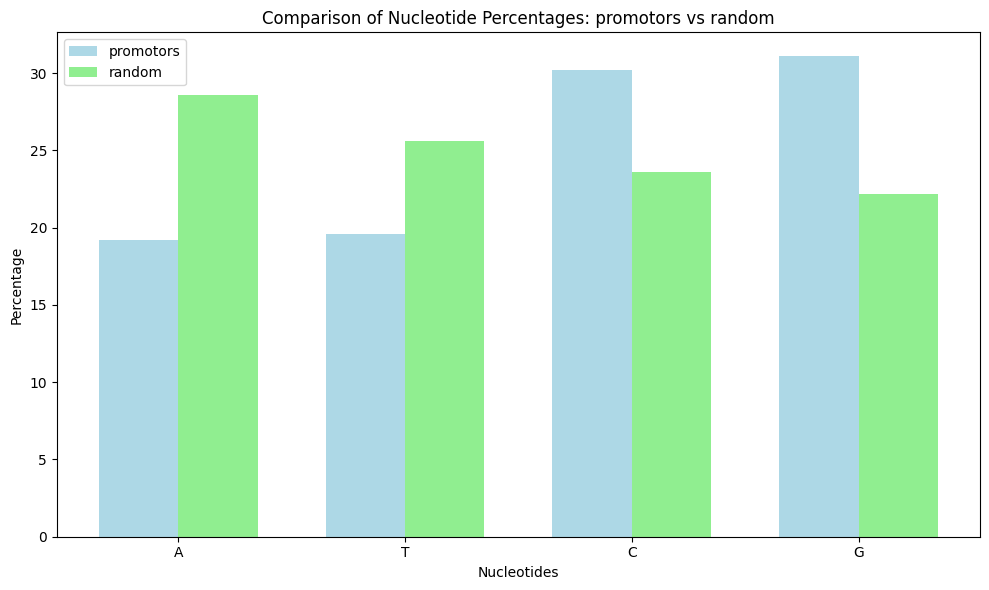

In [ ]:
plot_comparison(promotors, random, 'promotors', 'random')

The higher GC content is associated with the stability of sequences, which is typical for promoter regions. However, promoters are not exclusively GC-rich sequences, and we also aim to detect other types of promoters.